# VAE 구현 및 학습

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
import warnings
from google.colab import drive

drive.mount("/content/drive")
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_path = "/content/drive/MyDrive/MNIST"
model_path = "/content/drive/MyDrive/vae.pth"

input_dim = 28 * 28  # MNIST images
hidden_dim = 500
latent_dim = 10
batch_size = 64
learning_rate = 0.001
num_epochs = 10

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(
    root=data_path, train=True, download=True, transform=transform
)
test_dataset = datasets.MNIST(
    root=data_path, train=False, download=True, transform=transform
)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## 모델 정의 및 학습

In [4]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        h = torch.relu(self.fc2(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = torch.relu(self.fc1(z))
        h = torch.relu(self.fc2(h))
        x_recon = torch.sigmoid(self.fc_out(h))
        return x_recon


class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def forward(self, x):
        mu, logvar = self.encoder(x)

        # Reparameterization trick
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std)
        z = mu + epsilon * std

        x_recon = self.decoder(z)
        return x_recon, mu, logvar

In [5]:
def elbo_loss(x, x_recon, mu, logvar):
    recon_loss = nn.functional.binary_cross_entropy(x_recon, x, reduction="sum")
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

In [6]:
vae = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

vae.to(device)

VAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=784, out_features=500, bias=True)
    (fc2): Linear(in_features=500, out_features=500, bias=True)
    (fc_mu): Linear(in_features=500, out_features=10, bias=True)
    (fc_logvar): Linear(in_features=500, out_features=10, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=10, out_features=500, bias=True)
    (fc2): Linear(in_features=500, out_features=500, bias=True)
    (fc_out): Linear(in_features=500, out_features=784, bias=True)
  )
)

In [7]:
vae.train()
for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, (images, _) in enumerate(train_loader):
        images = images.view(-1, input_dim)
        optimizer.zero_grad()

        images = images.to(device)
        x_recon, mu, logvar = vae(images)

        loss = elbo_loss(images, x_recon, mu, logvar)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")

Epoch 1, Loss: 152.0079
Epoch 2, Loss: 118.7152
Epoch 3, Loss: 113.8425
Epoch 4, Loss: 110.6517
Epoch 5, Loss: 108.4254
Epoch 6, Loss: 106.9890
Epoch 7, Loss: 105.5884
Epoch 8, Loss: 104.4442
Epoch 9, Loss: 103.5913
Epoch 10, Loss: 102.9234


In [8]:
torch.save(vae.state_dict(), model_path)

## 실행 결과

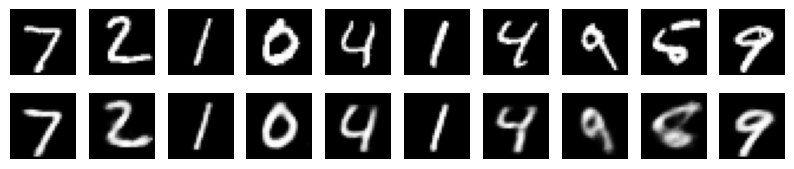

In [9]:
vae.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.view(-1, input_dim)
        images = images.to(device)
        x_recon, _, _ = vae(images)
        break

images = images.cpu().view(-1, 28, 28)
x_recon = x_recon.cpu().view(-1, 28, 28)

fig, axes = plt.subplots(2, 10, figsize=(10, 2))
for i in range(10):
    axes[0, i].imshow(images[i], cmap="gray")
    axes[0, i].axis("off")
    axes[1, i].imshow(x_recon[i], cmap="gray")
    axes[1, i].axis("off")
plt.show()